In [1]:
import numpy
import numpy as np
from abcsmcbare import abcsmc
from abcsmcbare import input_output
from abcsmcbare import kernels
from abcsmcbare import abcModel
from abcsmcbare import tolerance

from abcsmcbare.KernelType import KernelType
from abcsmcbare.PriorType import PriorType
from abcsmcbare.Prior import Prior

import matplotlib
%matplotlib inline
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import re

%load_ext autoreload
%autoreload 2
matplotlib.rcParams['savefig.dpi'] = 3 * matplotlib.rcParams['savefig.dpi']

Set up the simulation functions
===
For this example, we just use a simple ODE simulation of **lotka volterra** system.
I am being lazy and considering my two systems to just be the same ODE but different parameter values.

In [2]:
pickling = True
plot = True
plotTimeSeries = True
debug = 1#or 0 or 2 (higher the more details)
randomSeed = None #or an integer
timing = False
fname = "_results_"  # outfolder
custom_kernel = False
restart = False
mode = 0

if randomSeed is not None:
    print "#### Seeding random number generator : ", randomSeed
    numpy.random.seed(randomSeed)

modelKernel = 0.7
nparticles = 200

kernel = KernelType.component_wise_uniform  #check out kernalType.py

nbatch = 10

setup the distance function, the stimulation function, the priors, and model classes
===
For this example, we just use a simple ODE simulation of **lotka volterra** system.
I am being lazy and considering my two systems to just be the same ODE but different parameter values.



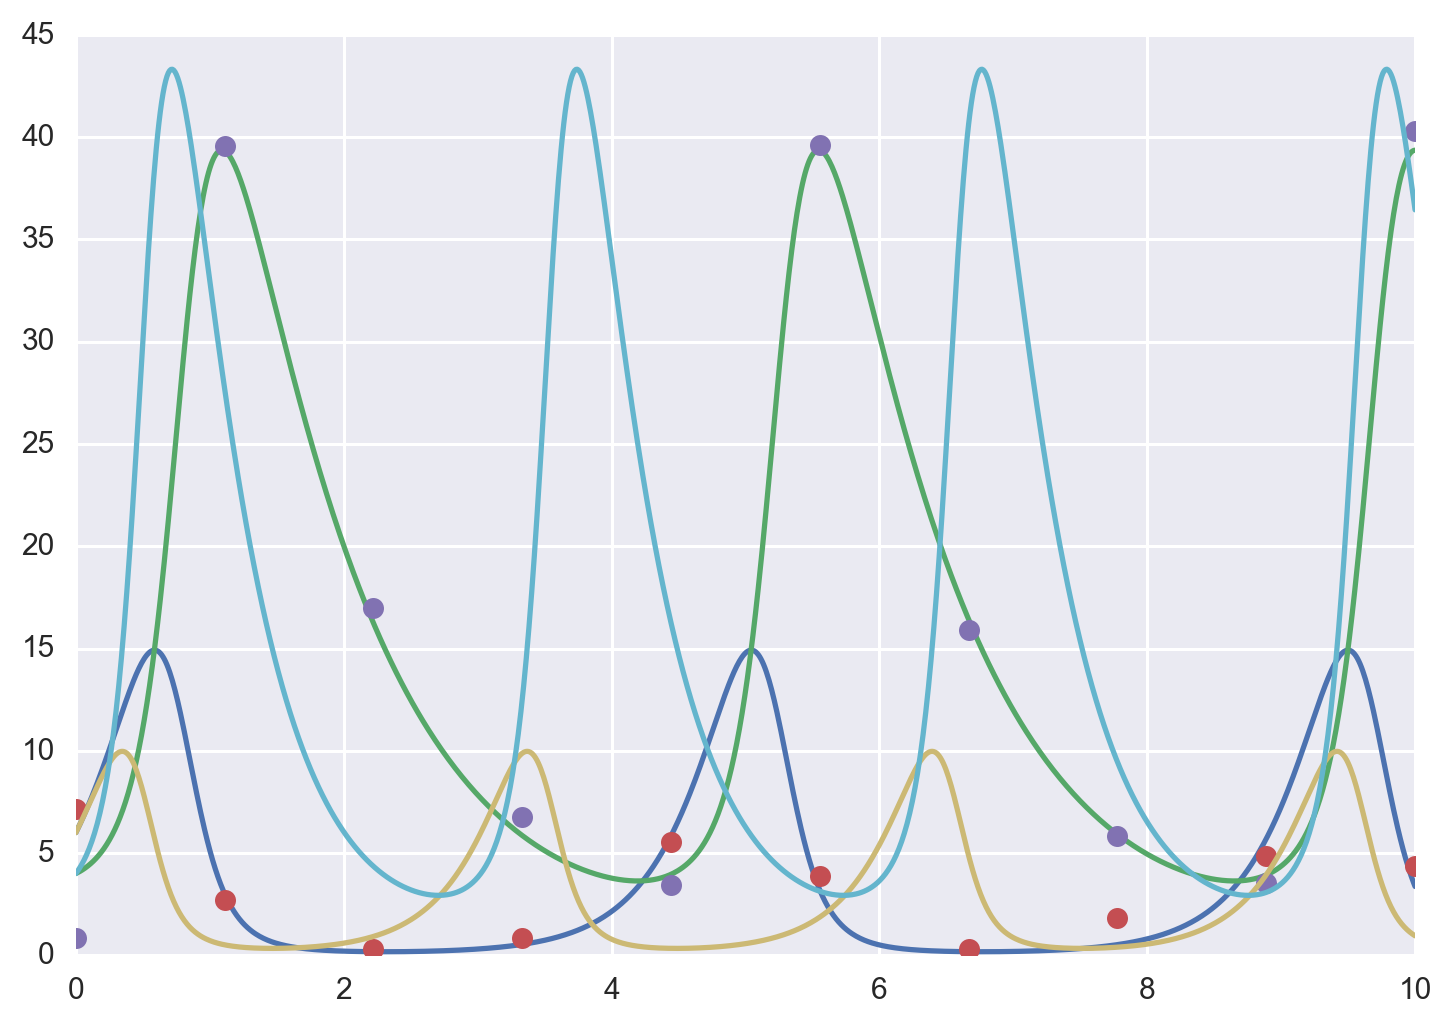

In [3]:
def modelODE( (x,y), t, parameter ):
    
    if x > 100 or y > 100 or x < -100 or y < -100:
        return (0,0)
    
    alpha   = parameter[0]
    beta    = parameter[1]
    delta   = parameter[2]
    gamma   = parameter[3]

    dx = alpha * x - beta * y * x
    dy = delta * x * y - gamma * y
    
    return [dx,dy]

ic = [ 6, 4 ]
finalT = 10
ts = np.linspace(0, finalT, 1000)
ts2 = np.linspace(0, finalT, 10)

actualParameters = [ 3, 0.2, 0.3, 1 ]
#actualParameters = [ 5, 0.5, 0.3, 1 ]

r  = scipy.integrate.odeint(modelODE, ic, ts, args=(actualParameters,))
r2 = scipy.integrate.odeint(modelODE, ic, ts2, args=(actualParameters,))
plt.plot( ts, r)
plt.hold(True)

err = scipy.randn(r2.shape[0],r2.shape[1])

plt.plot(ts2,r2+err*1.0,'o')
plt.hold(True)

ic = [ 6, 4 ]
finalT = 10
ts2 = np.linspace(0, finalT, 10)

actualParameters2 = [ 3, 0.2, 0.7, 2 ]
r3  = scipy.integrate.odeint(modelODE, ic, ts, args=(actualParameters2,))
plt.plot(ts,r3)

def dist_metric(d,x,_unused1,_unused2):
    distance = np.sum((d-x)**2)**0.5
    #if distance < 20:
    #    printOcc(distance)
    return distance

def simulation(paramsArray, pool=None):
    fullParams = [np.concatenate((x, actualParameters[-2:])) for x in paramsArray]
    r = [scipy.integrate.odeint(modelODE, ic, ts2, (x,)) for x in fullParams]
    return np.array(r)
    #return scipy.integrate.odeint(modelODE, ic, ts2, args=(param,))

    
def simulation2(paramsArray, pool=None):
    fullParams = [np.concatenate((x, actualParameters2[-1:])) for x in paramsArray]
    r = [scipy.integrate.odeint(modelODE, ic, ts2, (x,)) for x in fullParams]
    return np.array(r)
    #return scipy.integrate.odeint(modelODE, ic, ts2, args=(param,))

x = 0.0
y = 5.0
p1p = Prior(type=PriorType.uniform, lower_bound=x, upper_bound=y)

parameterPriors = [p1p,p1p]
parameterPriors2 = [p1p,p1p,p1p]



models = []

model1 = abcModel.AbcModel(name='M1',
                           simulationFn=simulation,
                           distanceFn=dist_metric,
                           nparameters=2,
                           prior=parameterPriors)
model2 = abcModel.AbcModel(name='M2',
                           simulationFn=simulation2,
                           distanceFn=dist_metric,
                           nparameters=3,
                           prior=parameterPriors2)


models = [model1,model2]
names  = [x.name for x in models]
nmodels = len(models)
modelprior = [1 / float(nmodels)] * nmodels

# set the required kernel functions
kernelfn = kernels.get_kernel
kernelpdffn = kernels.get_parameter_kernel_pdf
perturbfn = kernels.perturb_particle

Setup the Epsilon Schedule
===

In [4]:
niter = 15
firstEpsilon = 75
lastEpsilon  = 10#rstEpsilon * 0.01
tol_type = 'exp'
epsilonSchedule = tolerance.Tolerance(tol_type, lastEpsilon, firstEpsilon, niter).tol

epsilonSchedule

array([ 75.        ,  64.94666985,  56.24093232,  48.70215018,
        42.17389958,  36.52072442,  31.62532576,  27.38612788,
        23.71517074,  20.53628486,  17.78351083,  15.39973076,
        13.33548306,  11.5479362 ,  10.        ])

Run the actual ABC SMC
===
If you pass in just one of the models, etc then it just does parameter inference, if you pass in two models, it does model selection

Certain files will get saved to disk:
- allResults (which is a list containing 'abcsmcresults' classes of each of the populations run)
- a folder called 'copy' which is useful if you are doing a restart (it always contains useful points to rstart from the last population - just set restart to True, make sure your epsilon starts from the right point - so if you stopped at epsilon=2.0, then start the next one at 2.0 or slightly below that)

In [5]:
restart = False
fname = '_results_'
io = input_output.InputOutput(fname, restart)
io.create_output_folders(nparticles, pickling)

abcSmcInstance = abcsmc.Abcsmc(models=models,
                               nparticles=nparticles,
                               modelprior=modelprior,
                               data=r2, # beta=info_new.beta,
                               nbatch=nbatch,
                               model_kernel=modelKernel,
                               debug=debug,
                               timing=timing,
                               io=io,
                               # distancefn=distancefn,
                               kernel_type=kernel,
                               kernelfn=kernelfn,
                               kernelpdffn=kernelpdffn,
                               perturbfn=perturbfn)


if restart:
    abcSmcInstance.fill_values(io.read_pickled(fname))

allResults = abcSmcInstance.run_schedule(epsilonSchedule,adaptiveEpsilon=False)

top folder name is _results_20161018_121519 (useful e.g. if you are restarting because in such cases, this is the folder name you should pass in)
### Found special kernel case 1 for model  0 ###
### Found special kernel case 1 for model  1 ###
### iter:1, eps=75.00, sampled=231, accepted=0.87
model marginals: [0.4750000000000003, 0.5250000000000004]
### iter:2, eps=64.95, sampled=2283, accepted=0.09
model marginals: [0.57168890804487538, 0.42831109195512457]
### iter:3, eps=56.24, sampled=1767, accepted=0.11
model marginals: [0.42844793637979489, 0.57155206362020494]
### iter:4, eps=48.70, sampled=1393, accepted=0.14
model marginals: [0.76542978193300137, 0.23457021806699743]
### iter:5, eps=42.17, sampled=803, accepted=0.25
model marginals: [0.83066782643614434, 0.16933217356385627]
### iter:6, eps=36.52, sampled=804, accepted=0.25
model marginals: [0.89678394032240771, 0.10321605967759304]
### iter:7, eps=31.63, sampled=822, accepted=0.24
model marginals: [0.95637962446085567, 0.0436

/Users/oofaish/Projects/jupyter/venv/lib/python2.7/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


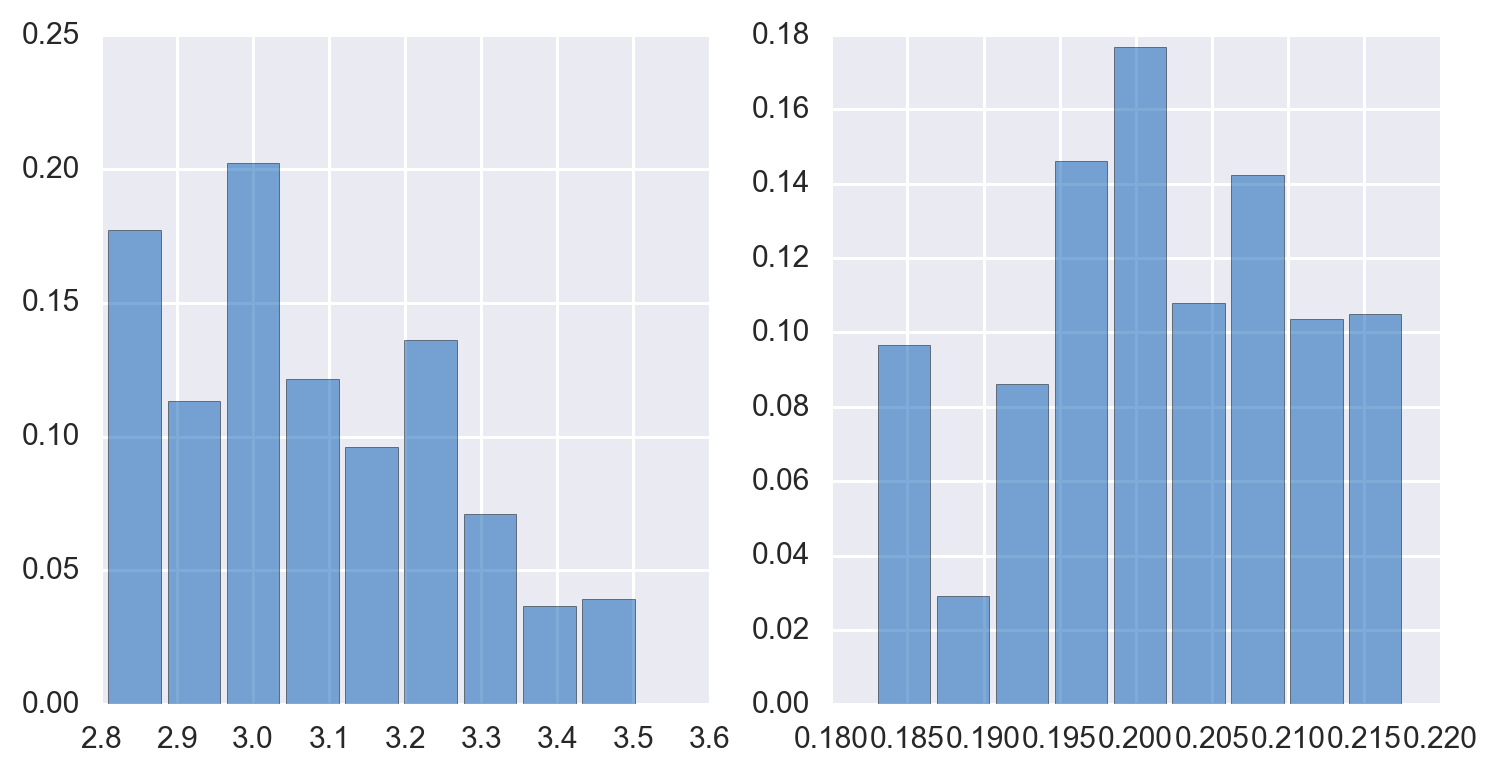

In [6]:
from abcsmcbare import plotter
#plot the estimated posterior of the model 0 int he last population
plotter.plotHistogram(allResults[-1],0,models=models)

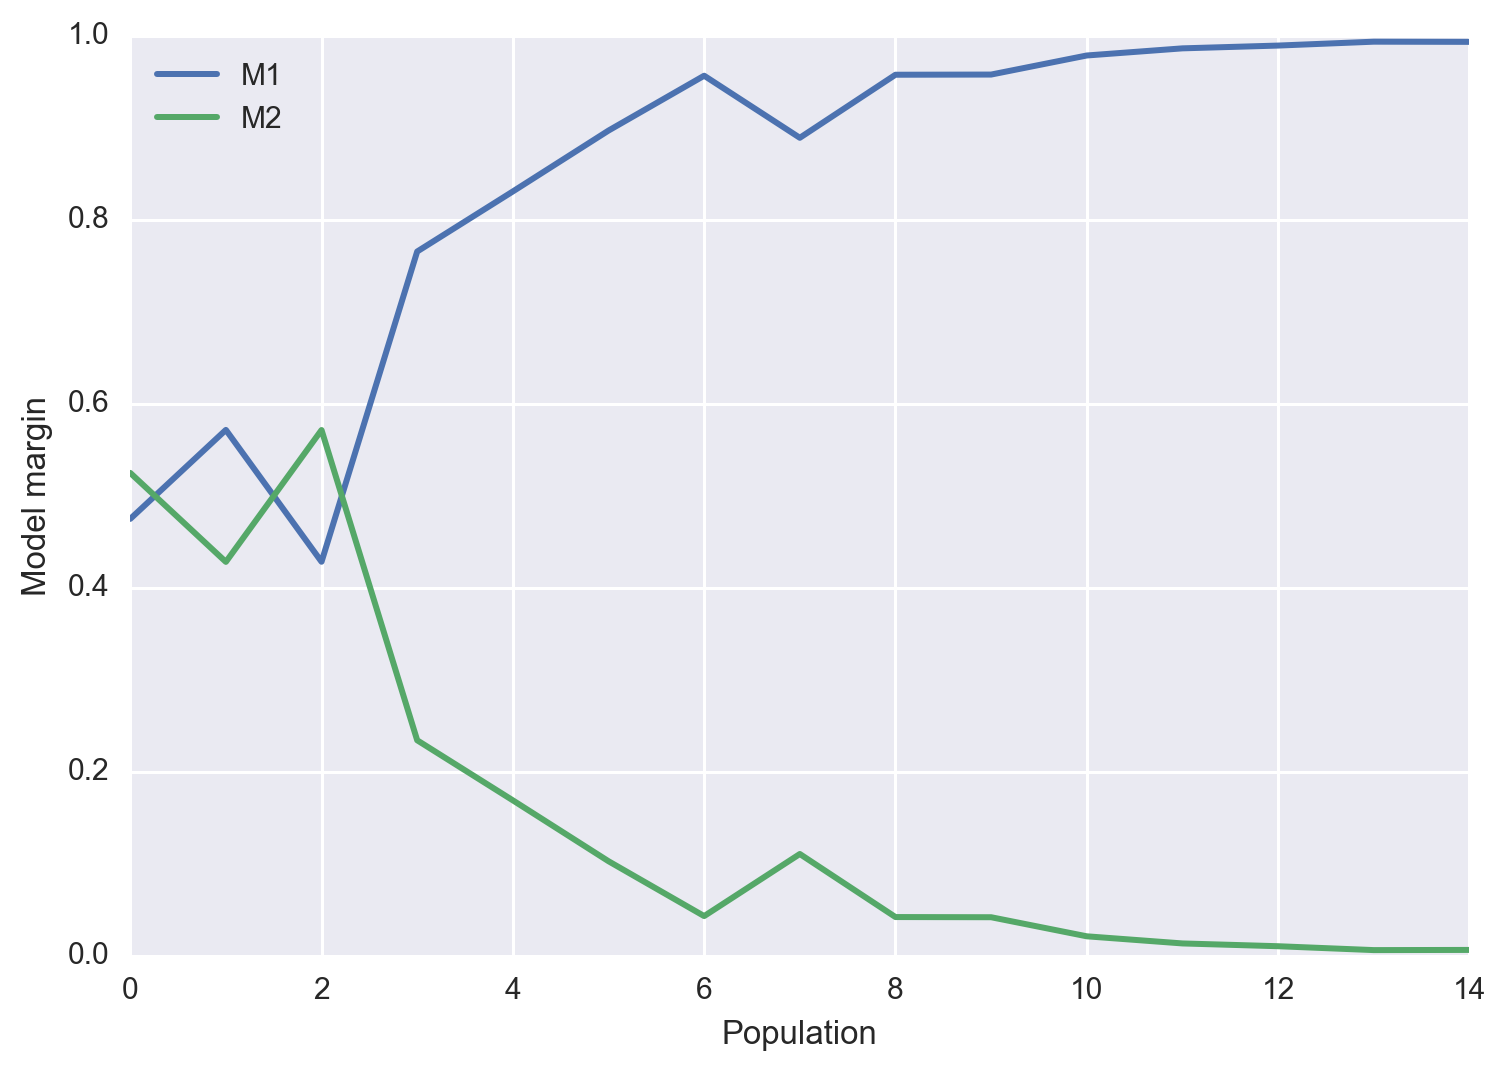

In [7]:
#plot model margin as we progress through populations
#model1 is clearly winning (rightly so)
plotter.modelMarginsByPopulation(allResults, models)

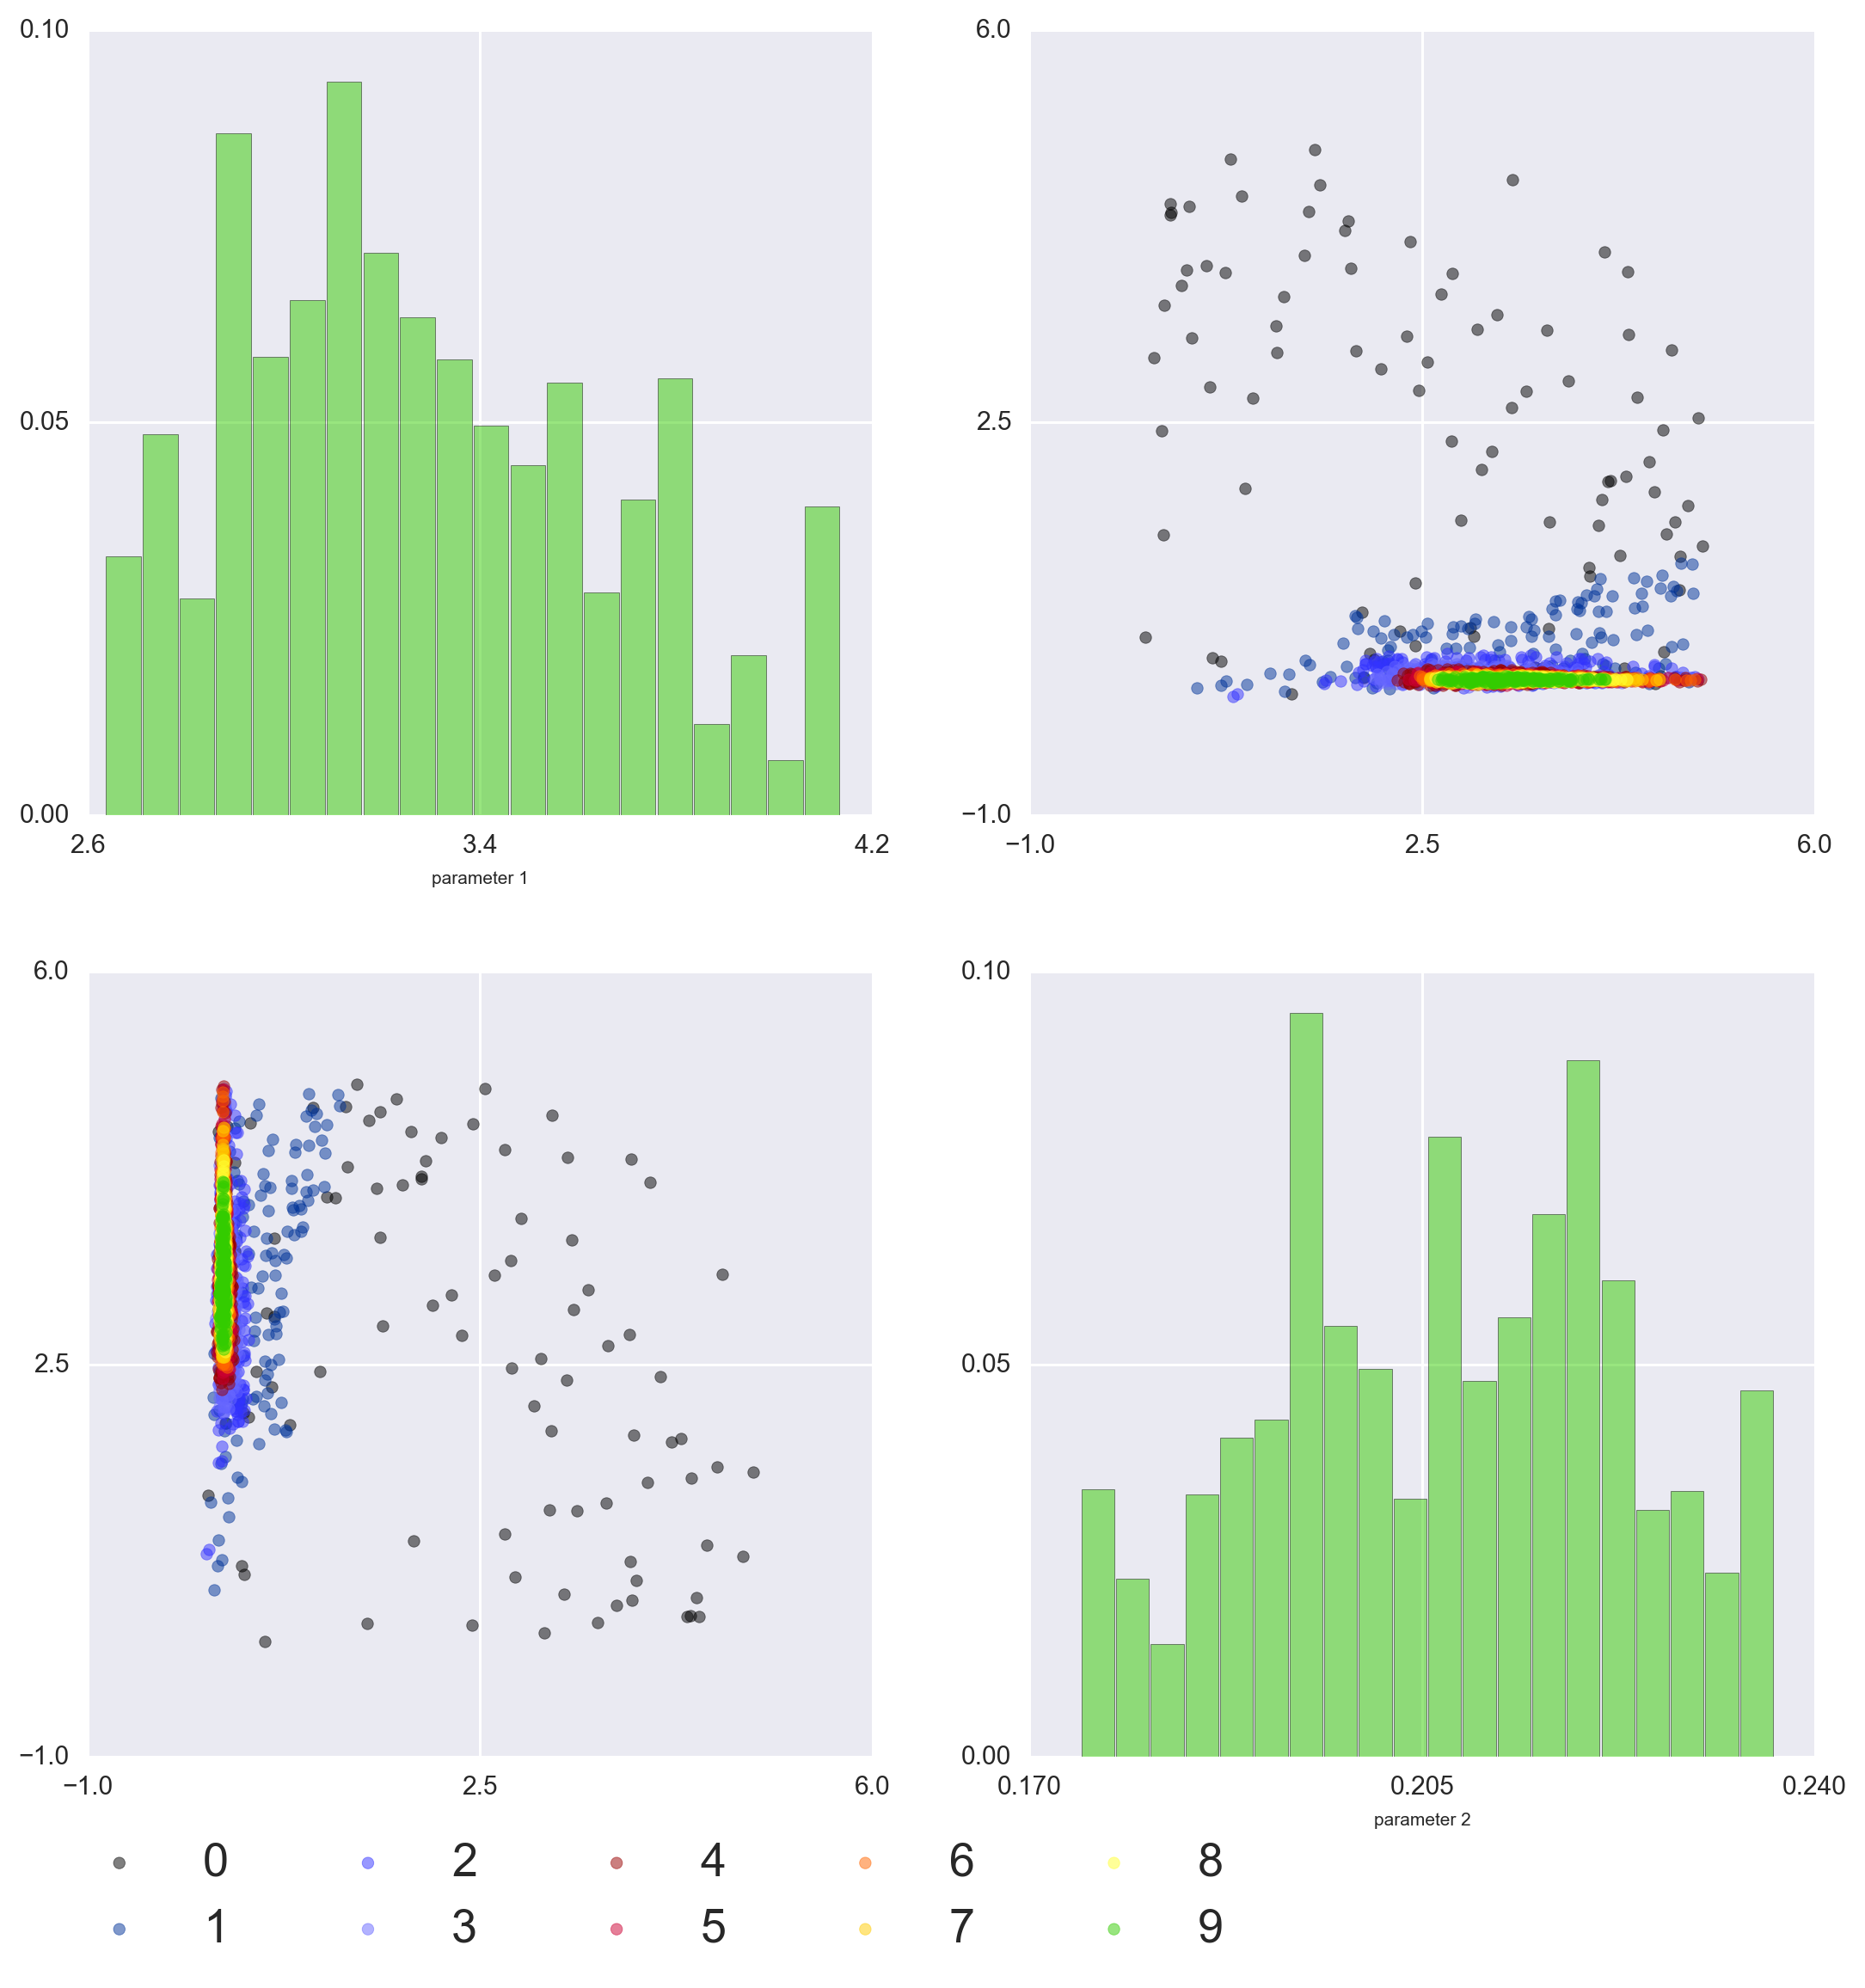

In [8]:
#do a pairplot of the parameters (for all 10 populations (hence range(10)))
plotter.doPairPlot(allResults, 0,range(10), models)